In [26]:
import os

import torch
from PIL import Image
from matplotlib.pyplot import imshow

In [27]:
%load_ext dotenv
%dotenv
%matplotlib inline

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [28]:
project_root: str = os.environ.get("PROJECT_ROOT", "")
test_image_path: str = f"{project_root}/datasets/ocr/高雄市ZS-0786.jpg"

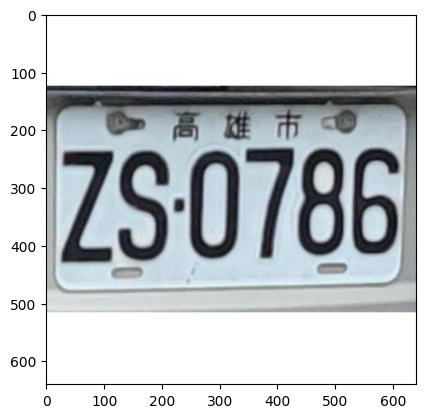

In [29]:
image = Image.open(test_image_path)
imshow(image)

# EasyOCR

In [30]:
image.size

(640, 640)

In [31]:
import easyocr

In [32]:
reader = easyocr.Reader(["en"], gpu=False)

Using CPU. Note: This module is much faster with a GPU.


## Use PIL format

In [33]:
result: str = reader.readtext(image)
result

[([[219, 156], [447, 156], [447, 224], [219, 224]],
  '6 # 7',
  0.1505798876092994),
 ([[3, 203], [634, 203], [634, 449], [3, 449]], '2S0786', 0.9100890084644746)]

## Use picture directly

In [34]:
result = reader.readtext(test_image_path)
result

[([[214, 156], [452, 156], [452, 228], [214, 228]],
  '6 4 m',
  0.35542552795309446),
 ([[4, 206], [633, 206], [633, 448], [4, 448]], '2S0786', 0.868515655823656)]

# Tesseract

In [35]:
import pytesseract

In [36]:
tesseract_config: str = "--psm 6 --oem 1"

In [37]:
result = pytesseract.image_to_string(image, lang="eng", config=tesseract_config)
result

'750786\n'

# TrOCR

In [38]:
from transformers import BitsAndBytesConfig, TrOCRProcessor, VisionEncoderDecoderModel

In [39]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed", clean_up_tokenization_spaces=True)
model = VisionEncoderDecoderModel.from_pretrained(
	"DunnBC22/trocr-base-printed_license_plates_ocr",
	quantization_config=BitsAndBytesConfig(
		load_in_4bit=True,
		bnb_4bit_quant_type="nf4",
		bnb_4bit_compute_dtype=torch.bfloat16,
		bnb_4bit_quant_storage=torch.bfloat16,
	),
	torch_dtype=torch.bfloat16,
	low_cpu_mem_usage=True,
)

In [44]:
model

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear4bit(in_features=768, out_features=768, bias=False)
              (key): Linear4bit(in_features=768, out_features=768, bias=False)
              (value): Linear4bit(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear4bit(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense

In [40]:
encode_image = processor(image.convert("RGB"), return_tensors="pt").pixel_values

In [41]:
generated_ids = model.generate(encode_image, max_length=20)

/home/hermeschen/Repo/taiwan-license-plate-recognition/.venv/lib/python3.12/site-packages/transformers/generation/utils.py:1885: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


In [42]:
result = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
result

'ZS0786'